# Bayesian parameter estimation of Montbrio Model

The aim of this work is to infer the parameter of single Montbrio model by HMC sampling.

In [1]:
import os
import sys
import time

import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
import time

import numpy as np
import scipy as sci
import pylab as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import pystan
from parse_csv import parse_csv2
from read_csvs import read_samples

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [5]:
%pylab inline

plt.style.use('seaborn-talk')


Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/jhub-2020.03/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sci']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [7]:
pwd

'/home/meysam/InferringRestingState/MontPazRoxin/NMM_MontPazRoxin/InferringMontPazRoxin_syntheticdata_I3sde1'

In [8]:
cwd = os.getcwd()
cwd

'/home/meysam/InferringRestingState/MontPazRoxin/NMM_MontPazRoxin/InferringMontPazRoxin_syntheticdata_I3sde1'

# Simulation of Montbrio model


$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $



In [9]:
def Montbrio_model(v0, r0, delta, eta, J, I_input, dt, sigma):
    vs, rs = [v0], [r0]
    nsteps=len(I_input)
    for i in range(nsteps-1):
        v, r = vs[-1], rs[-1]
        dr =(delta/np.pi) +2*r*v
        dv = v**2  -(np.pi*r)**2 + J*r+ eta +I_input[i]
        rs.append(r + dt * dr +sqrt(dt) *sigma * randn())
        vs.append(v + dt * dv +sqrt(dt) *sigma * randn())
    v,r = np.array(vs), np.array(rs)
    return v,r

In [10]:
def plot_nullcline(ax, delta, eta, J, I0, linewidth=3, style='--',  vmin=-20,vmax=20):
    v = np.linspace(vmin,vmax,100000)
    nullcline_v=-delta/(2*np.pi*v)
    nullcline_r=v**2  -(np.pi*(-delta/(2*np.pi*v)))**2 + J*(-delta/(2*np.pi*v))+ eta +I0
    ax.plot(v, nullcline_v , style, color='red', linewidth=linewidth)
    ax.plot(v, nullcline_r , style, color='blue', linewidth=linewidth)

In [11]:
def MontbrioFlow(x, t, delta, eta, J, I0):
    Fr=(delta/np.pi) +(2*x[0]*x[1])
    Fv=(x[1]**2)  -(np.pi*x[0])**2 + J*x[0]+ eta +I0
    F=np.array([Fr, Fv])
    return F

In [13]:
def plot_vector_field(ax, param, xrange, yrange, steps=1000):
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    dx,dy = MontbrioFlow([X,Y],0,**param)   
    ax.streamplot(X,Y,dx, dy, density=2.0, color='lightgray')
    ax.contour(X,Y,dx, [0], linestyles='--', linewidths=3, colors="blue", alpha=0.9)
    ax.contour(X,Y,dy, [0], linestyles='--', linewidths=3, colors="red", alpha=0.9)
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

# Load data input 

In [14]:
data_iput_filename=str('data_input_mpr_I3_sde1')

In [15]:
data_input = dict(load(cwd+'/data_input_files/'+ str(data_iput_filename)+ '.R.npz'))

#data = pystan.read_rdump('data.R')

In [16]:
data_input

{'nd': array([], dtype=float64),
 'nt': array(10000),
 'dt': array(0.01),
 't0': array(-30.),
 'Ts': array([-30.  , -29.99, -29.98, ...,  69.97,  69.98,  69.99]),
 'I_input': array([0., 0., 0., ..., 0., 0., 0.]),
 'rs': array([0.5       , 0.46732946, 0.43392011, ..., 0.02587837, 0.04049391,
        0.0430234 ]),
 'vs': array([-3.        , -2.89050958, -2.8081971 , ..., -2.15863009,
        -2.16420137, -2.16193412]),
 'rs_norm': array([-0.66177305, -0.68148099, -0.70163461, ..., -0.94777877,
        -0.9389622 , -0.93743633]),
 'vs_norm': array([-0.79845367, -0.76628956, -0.74210929, ..., -0.55129128,
        -0.55292791, -0.55226187]),
 'r_init': array(0.5),
 'v_init': array(-3.),
 'delta_true': array(0.7),
 'eta_true': array(-4.6),
 'J_true': array(14.5),
 'rlim': array([0., 8.]),
 'vlim': array([-8.,  8.])}

In [17]:
nt=data_input['nt']
dt=data_input['dt']
Ts=data_input['Ts']

vs=data_input['vs']
rs=data_input['rs']

v0=data_input['v_init']
r0=data_input['r_init']

I_input=data_input['I_input']


delta_true=data_input['delta_true']
eta_true=data_input['eta_true']
J_true=data_input['J_true']

In [18]:
ds=1

vs_decim=data_input['vs'][::ds]
rs_decim=data_input['rs'][::ds]
Ts_decim=data_input['Ts'][::ds]


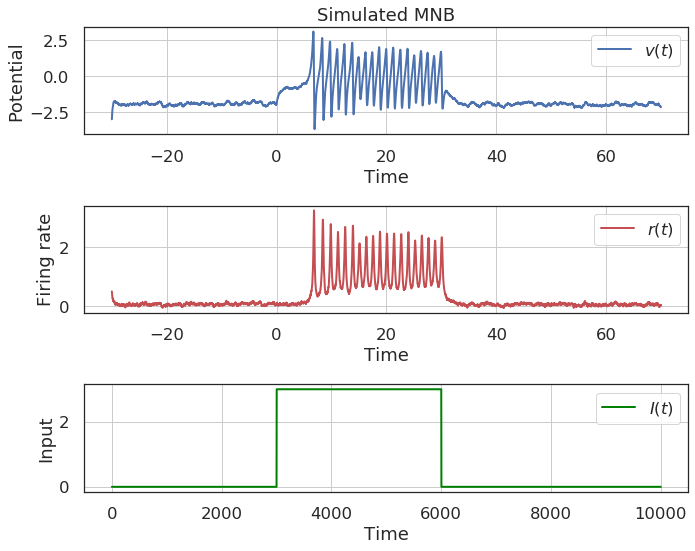

In [19]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(Ts, vs, 'b', linewidth=2, label='$v(t)$')
# plt.plot(Ts_decim, vs_decim, 'b.', linewidth=2, label='$v(t)$')
plt.xlabel('Time'); plt.ylabel('Potential'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()
plt.title('Simulated MNB')
plt.subplot(312)
plt.plot(Ts, rs, 'r', linewidth=2, label='$r(t)$')
# plt.plot(Ts_decim, rs_decim, 'r.', linewidth=2, label='$v(t)$')
plt.xlabel('Time'); plt.ylabel('Firing rate'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()

plt.subplot(313)
plt.plot(I_input, 'green', linewidth=2, label='$I(t)$')
plt.xlabel('Time'); plt.ylabel('Input'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()
plt.show()

# Now lets infer the parameters delta, eta, J.

In [20]:
chain=1

# SDE cen (Bounded r and v, delta, eta, J, with noinformative prior)

In [21]:
cwd = os.getcwd()
curr_dir=cwd
curr_dir

'/home/meysam/InferringRestingState/MontPazRoxin/NMM_MontPazRoxin/InferringMontPazRoxin_syntheticdata_I3sde1'

In [22]:
model=str('MPR_centerized')

In [23]:
!cat $model'.stan'

data {
    int nt;
    real dt;
    real delta_true;
    real eta_true;
    real J_true;
    real r_init;
    real v_init;
    real rlim[2];
    real vlim[2];
    vector[nt] rs;
    vector[nt] vs;
    vector[nt] I_input;
}

transformed data {
    real std_prior=0.1;
    int ds=1; 
    int nts=nt/ds;
    vector[nts] rs_decim;
    vector[nts] vs_decim;
    
    for (i in 1:nts){
         rs_decim[i]=rs[ds*(i-1)+1];
         vs_decim[i]=vs[ds*(i-1)+1];
         }
}

parameters {
    vector<lower=rlim[1], upper=rlim[2]>[nts] r;
    vector<lower=vlim[1], upper=vlim[2]>[nts] v;
    real  delta;
    real  eta;
    real  J;
    real<lower=0.0> eps;
    real<lower=0.0> sig;  
}

transformed parameters {
}

model {
    vector[nts] rhat;
    vector[nts] vhat;

    /* priors*/
 

    eps ~ cauchy(0., 0.1);   
    sig ~ cauchy(0., 0.1); 
 
    
    /* integrate & predict */

    r[1]~ normal(r_init, std_prior);
    v[1]~ normal(v_init, std_prior);
    
        
    for (t in 1:(nts-1)) {
          

### Compile and Run SDE_cen.

compile with cmdstan

In [24]:
#! cd /home/meysam/cmdstan-2.17.1 && make $curr_dir/$model && cd $curr_dir

##  Run mnb_sde_cen

In [25]:
# %%bash

# del=0.99
# depth=10
# iter=2000
# warm_iter=2000

# alg=hmc
# model=MPR_cen_uniform
# data_input=data_input_mpr_I3_sde1.R
# data_output=data_output_${alg}_${model}
# mkdir -p ${data_output}

# log_file=report_convergence_${model}.txt

# echo "HMC started for" ${alg}_${model} >> ${log_file}

# for i in `seq 4`
# do
#     ./$model id=$i\
#         sample save_warmup=0 num_warmup=${warm_iter} num_samples=${iter} \
#         adapt \
#         delta=${del} \
#         algorithm=${alg} \
#         engine=nuts \
#         max_depth=${depth}  \
#         data file=data_input_files/${data_input}\
#         output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
#         &> ${data_output}/output_${alg}_${model}_$i.out &
# done
# #wait

# echo "HMC Finished for" ${alg}_${model} >> ${log_file}

In [26]:
fit_foldername="data_output_hmc_"+model
fit_filename="output_hmc_"+model

In [27]:
dir_data_output=cwd+"/"+fit_foldername

In [28]:
!tail -n2 $dir_data_output/*$model*out

==> /home/meysam/InferringRestingState/MontPazRoxin/NMM_MontPazRoxin/InferringMontPazRoxin_syntheticdata_I3sde1/data_output_hmc_MPR_cen_uniform/output_hmc_MPR_cen_uniform_1.out <==
               46394.2 seconds (Total)


==> /home/meysam/InferringRestingState/MontPazRoxin/NMM_MontPazRoxin/InferringMontPazRoxin_syntheticdata_I3sde1/data_output_hmc_MPR_cen_uniform/output_hmc_MPR_cen_uniform_2.out <==
               37870.6 seconds (Total)


==> /home/meysam/InferringRestingState/MontPazRoxin/NMM_MontPazRoxin/InferringMontPazRoxin_syntheticdata_I3sde1/data_output_hmc_MPR_cen_uniform/output_hmc_MPR_cen_uniform_3.out <==
               53206 seconds (Total)


==> /home/meysam/InferringRestingState/MontPazRoxin/NMM_MontPazRoxin/InferringMontPazRoxin_syntheticdata_I3sde1/data_output_hmc_MPR_cen_uniform/output_hmc_MPR_cen_uniform_4.out <==
               44728.6 seconds (Total)


==> /home/meysam/InferringRestingState/MontPazRoxin/NMM_MontPazRoxin/InferringMontPazRoxin_syntheticdata_I3sde1/da

In [29]:
#%run parse_csv.py

## check the convergence 

In [31]:
chain=1

In [32]:
fit_filename_csv= fit_filename +'_'+ str(chain)+'.csv'
fit_filename_out= fit_filename +'_'+ str(chain)+'.out'

In [33]:
with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
    lines = f.readlines()
    last_lines = lines[-7:]
    print (last_lines[1], last_lines[3], last_lines[4], last_lines[5]  )

Iteration: 5000 / 5000 [100%]  (Sampling)
  Elapsed Time: 33726.4 seconds (Warm-up)
                12667.8 seconds (Sampling)
                46394.2 seconds (Total)



In [34]:
from report_algconfigs import hmc_config
num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

num_samples: 2500
num_warmup: 2500
save_warmup: 0
adapt_delta: 0.98999999999999999
max_depth: 10
total_time: 46394.2


In [35]:
num_samples=int(num_samples)

In [36]:
if int(save_warmup)==0:
    Burnin=0
nSample=num_samples-Burnin

## posterior predictive density 

In [37]:
fit= parse_csv2(dir_data_output+"/", fit_filename_csv)

In [38]:
for key, val in fit.items():
    print(key, val.shape)

lp__ (2500,)
accept_stat__ (2500,)
stepsize__ (2500,)
treedepth__ (2500,)
n_leapfrog__ (2500,)
divergent__ (2500,)
energy__ (2500,)
r (2500, 10000)
v (2500, 10000)
delta (2500,)
eta (2500,)
J (2500,)
eps (2500,)
sig (2500,)
rhat_qqc (2500, 10000)
vhat_qqc (2500, 10000)
r_ppc (2500, 10000)
v_ppc (2500, 10000)
log_lik (2500, 10000)


In [39]:
Burnin=0
nSample=fit['lp__'].shape[0]-Burnin

In [40]:
eps_est=fit['eps'][-nSample:]
sig_est=fit['sig'][-nSample:]

print("eps_est=", eps_est.mean())
print("sig_est=", sig_est.mean())

eps_est= 0.006205203236
sig_est= 0.07855905104


In [41]:
r_est=mean(fit['r'][-nSample:],axis=0)
v_est=mean(fit['v'][-nSample:],axis=0)

r_est_reg=mean(fit['r'][-nSample:],axis=0)
v_est_reg=mean(fit['v'][-nSample:],axis=0)

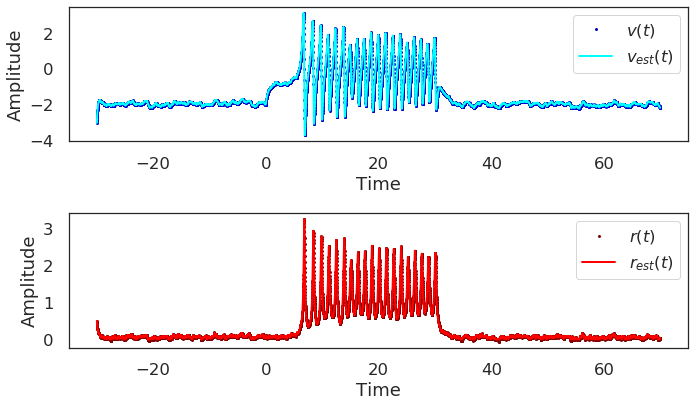

In [42]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(Ts_decim, vs_decim, '.', color='mediumblue', linewidth=1., label='$v(t)$')
plt.plot(Ts_decim, v_est_reg, 'aqua', linewidth=2.,label='$v_{est}(t)$')
plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout()

plt.subplot(212)
plt.plot(Ts_decim, rs_decim, '.', color='maroon', label='$r(t)$')
plt.plot(Ts_decim, r_est_reg, 'red', linewidth=2.,label='$r_{est}(t)$')
plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(dir_data_output,"Fitted_"+str(model)+"_chain_"+str(chain)+".png"))
plt.show()

In [43]:
r_ppc=fit['r_ppc']
v_ppc=fit['v_ppc']
rhat_qqc = fit['rhat_qqc']
vhat_qqc = fit['vhat_qqc']

r_ppc_lo, r_ppc_hi = percentile(r_ppc, [5, 95], axis=0)
v_ppc_lo, v_ppc_hi = percentile(v_ppc, [5, 95], axis=0)
rhat_qqc_lo, rhat_qqc_hi = percentile(rhat_qqc, [5, 95], axis=0)
vhat_qqc_lo, vhat_qqc_hi = percentile(vhat_qqc, [5, 95], axis=0)

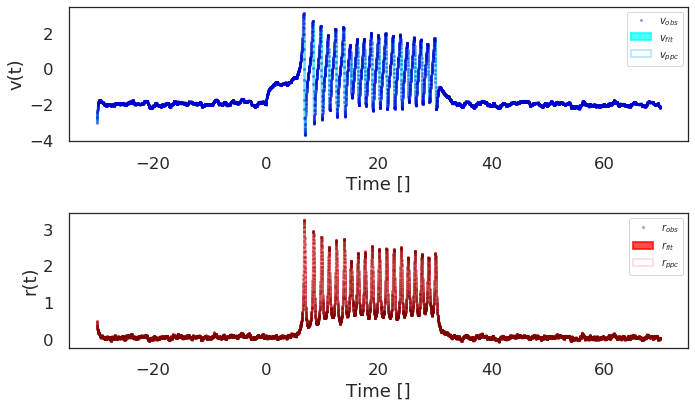

In [44]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
fill_between(Ts_decim, vhat_qqc_lo, vhat_qqc_hi, linewidth=2, alpha=0.7, facecolor='cyan', edgecolor='cyan',  label='$v_{fit}$')
fill_between(Ts_decim, v_ppc_lo, v_ppc_hi, linewidth=2, alpha=0.5, facecolor='none', edgecolor='lightskyblue', label='$v_{ppc}$')
plot(Ts_decim, vs_decim, '.', color='mediumblue', linewidth=2, alpha=0.4, label='$v_{obs}$')

plt.xlabel('Time []'); plt.ylabel('v(t)'); 
plt.legend(fontsize=10, loc='upper right')
plt.tight_layout()



plt.subplot(212)
fill_between(Ts_decim, rhat_qqc_lo, rhat_qqc_hi, linewidth=2, alpha=0.7, facecolor='red', edgecolor='red',  label='$r_{fit}$')
fill_between(Ts_decim, r_ppc_lo, r_ppc_hi, linewidth=2, alpha=0.5, facecolor='none', edgecolor='pink', label='$r_{ppc}$')
plot(Ts_decim, rs_decim, '.', color='maroon', linewidth=2, alpha=0.4, label='$r_{obs}$')

plt.xlabel('Time []'); plt.ylabel('r(t)'); 
plt.legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(dir_data_output,"PPC_"+str(model)+"_chain_"+str(chain)+".png"))

plt.show()

# Estimation Accuracy

In [45]:
from report_metrics import LSE,  LSE_obs, RMSE, Rmse_metric, canberra_metric

In [46]:
vs_decim.shape, v_est.shape

((10000,), (10000,))

In [47]:
LSE_val=LSE_obs(rs, r_ppc_lo, r_ppc_hi)+LSE_obs(vs, v_ppc_lo, v_ppc_hi)
print("LSE_val=", LSE_val)

LSE_val= 3.546892666625106


In [48]:
RMSE=Rmse_metric(rs_decim, r_est_reg)+Rmse_metric(vs_decim, v_est_reg)
print("RMSE=", RMSE)

RMSE= 0.008360883564457423


In [49]:
delta_est=fit['delta'][-nSample:]
eta_est=fit['eta'][-nSample:]
J_est=fit['J'][-nSample:]

In [50]:
print("delta_est=", delta_est.mean())
print("eta_est=", eta_est.mean())
print("J_est=", J_est.mean())

delta_est= 0.693974388
eta_est= -4.621209132
J_est= 14.540360360000001


In [51]:
params_label=['delta', 'eta', 'J']
#params_label=np.array(['delta', 'eta', 'J'])

params_true=np.array([delta_true, eta_true, J_true])
print("params_true=[delta, eta, J]=", params_true)

params_est_mean=np.array([delta_est.mean(), eta_est.mean(), J_est.mean()])
print("params_est_mean=[delta, eta, J]=", params_est_mean)


params_true=[delta, eta, J]= [ 0.7 -4.6 14.5]
params_est_mean=[delta, eta, J]= [ 0.69397439 -4.62120913 14.54036036]


In [52]:
RMSE_val=Rmse_metric(params_true, params_est_mean)
print("RMSE_val=", RMSE_val)

RMSE_val= 0.026552425749183185


In [53]:
params_true[0]-delta_est.mean()

0.006025611999999958

In [54]:
params_true[1]-eta_est.mean()

0.021209132000000075

In [55]:
params_true[2]-J_est.mean()

-0.040360360000001094

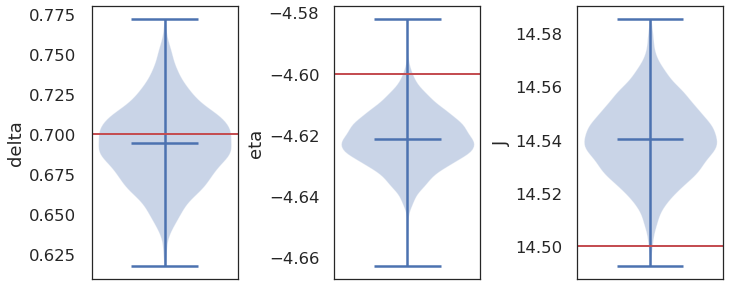

In [56]:
plt.figure(figsize=(10, 4))
for i, variables in enumerate([delta_est, eta_est, J_est]):
    plt.subplot(1,params_true.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=params_true[i], linewidth=2, color='r')
    plt.ylabel(str(params_label[i]))   
    plt.xticks([])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(os.path.join(dir_data_output,"EstimatedParams_"+str(model)+"_chain_"+str(chain)+".png"))
plt.show()

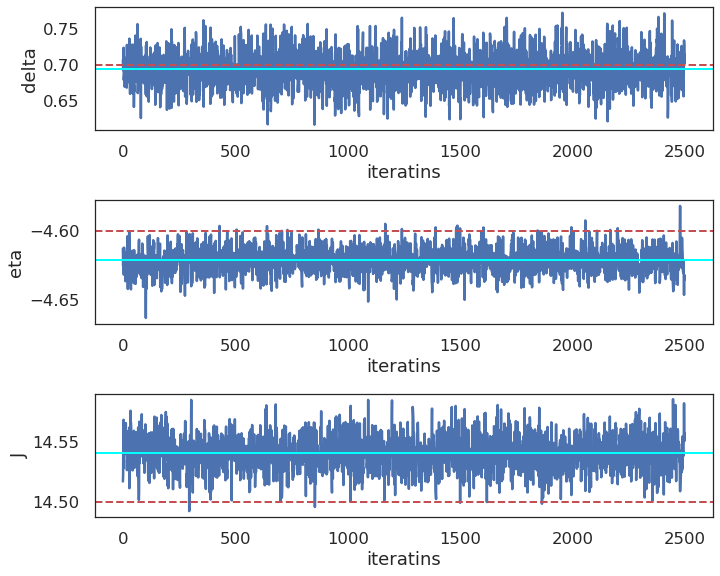

In [57]:
plt.figure(figsize=(10, 8))
for i, variables in enumerate([delta_est, eta_est, J_est]):
    plt.subplot(params_true.shape[0],1,i+1)
    plt.plot(variables)
    plt.axhline(y=params_true[i], linewidth=2, color='r', linestyle='--')
    plt.axhline(y=variables.mean(), linewidth=2, color='cyan')
    plt.ylabel(str(params_label[i]))   
    plt.xlabel('iteratins')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(os.path.join(dir_data_output,"MCMCParams_"+str(model)+"_chain_"+str(chain)+".png"))
plt.show()

In [58]:
parameters = [ {"delta":delta_true, "eta":eta_true, "J":J_true, "I0":0.},
               {"delta":delta_est.mean(), "eta":eta_est.mean(), "J":J_est.mean(), "I0":0.}]

In [59]:
alpha_true=eta_true/delta_true

alpha_est=eta_est.mean()/delta_est.mean()

alpha_true, alpha_est

(-6.571428571428571, -6.659048535376207)

In [60]:
beta_true=J_true/sqrt(delta_true)
beta_est=J_est.mean()/sqrt(delta_est.mean())

beta_true, beta_est

(17.330814835348708, 17.454340690200556)

In [61]:
eta_true/J_true, eta_est.mean()/J_est.mean()

(-0.3172413793103448, -0.3178194362165037)

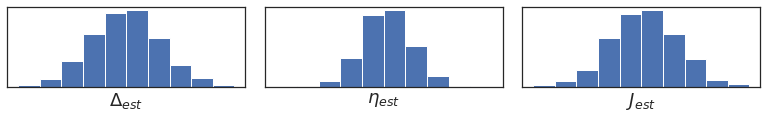

In [62]:
plt.figure(figsize=(11, 2))
plt.subplot(131)
plt.hist(delta_est)
plt.xlabel("$\Delta_{est}$")
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.hist(eta_est)
plt.xlabel("$\eta_{est}$")
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.hist(J_est)
plt.xlabel("$J_{est}$")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig(os.path.join(dir_data_output,"PairParams_"+str(model)+"_chain_"+str(chain)+".png"))
plt.show()

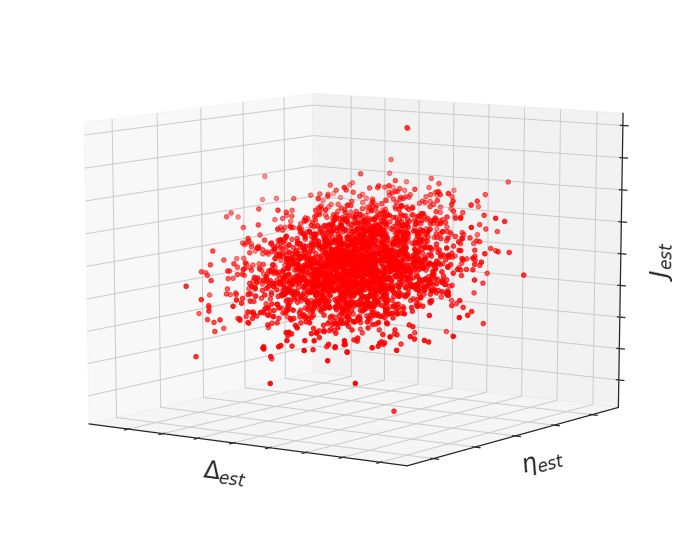

In [63]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x =delta_est
y =eta_est
z =J_est
ax.scatter(x, z, y, c='red', marker='o')
ax.set_xlabel("$\Delta_{est}$", fontsize=24)
ax.set_ylabel("$\eta_{est}$", fontsize=24)
ax.set_zlabel("$J_{est}$", fontsize=24)
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
ax.view_init(10, 125)
plt.tight_layout()
plt.savefig(os.path.join(dir_data_output,"PairParamsJoindist3d_"+str(model)+"_chain_"+str(chain)+".png"))
plt.show()

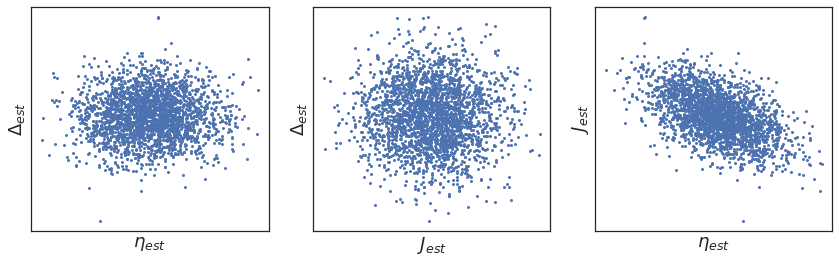

In [64]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(delta_est, eta_est,'.')
plt.ylabel("$\Delta_{est}$")
plt.xlabel("$\eta_{est}$")
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.plot(delta_est, J_est, '.')
plt.ylabel("$\Delta_{est}$")
plt.xlabel("$J_{est}$")
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.plot(J_est, eta_est, '.')
plt.xlabel("$\eta_{est}$")
plt.ylabel("$J_{est}$")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig(os.path.join(dir_data_output,"PairParamsJoindist_"+str(model)+"_chain_"+str(chain)+".png"))
plt.show()

In [65]:
delta_est=array([delta_est]).T
eta_est=array([eta_est]).T
J_est=array([J_est]).T

                        
params = {'delta_est': delta_est, 'eta_est': eta_est, 'J_est': J_est}
        
f=concatenate((delta_est, eta_est, J_est), axis=1)
df = pd.DataFrame(f, columns=['delta_est',  'eta_est', 'J_est' ])

In [66]:
df.dtypes

delta_est    float64
eta_est      float64
J_est        float64
dtype: object

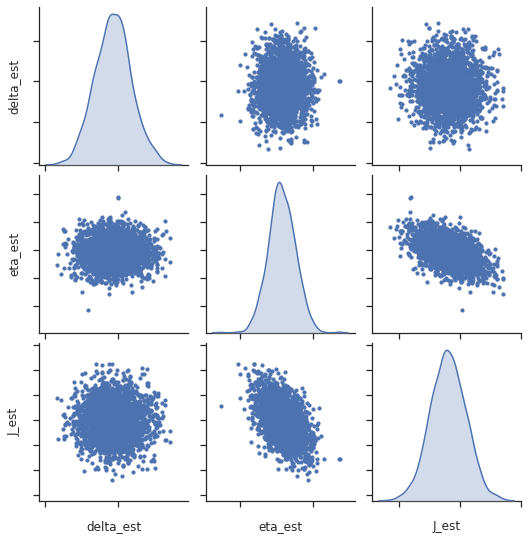

In [67]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df, diag_kind="kde", markers="o",plot_kws=dict(s=10, edgecolor="b", linewidth=1))
g.set(xticklabels=[])
g.set(yticklabels=[])
plt.savefig(os.path.join(dir_data_output,"PairParamsScatterdist3d_"+str(model)+"_chain_"+str(chain)+".png"))


In [68]:
df

,delta_est,eta_est,J_est
0,0.706626,-4.61293,14.5171
1,0.692564,-4.62524,14.5215
2,0.702988,-4.61902,14.5624
3,0.723542,-4.62085,14.5683
4,0.678927,-4.63169,14.5284
...,...,...,...
2495,0.703775,-4.63658,14.5543
2496,0.733651,-4.64628,14.5820
2497,0.727032,-4.63182,14.5607
2498,0.701874,-4.63218,14.5507


In [69]:
df.corr()

,delta_est,eta_est,J_est
delta_est,1.000000,0.026514,-0.031898
eta_est,0.026514,1.000000,-0.507110
J_est,-0.031898,-0.507110,1.000000


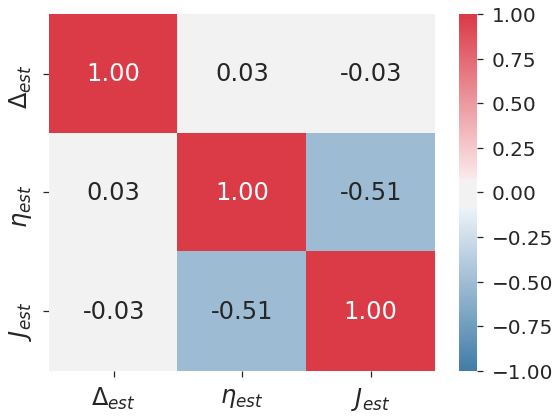

In [70]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
sns.heatmap(df.corr(), annot=True, robust=True, cmap=cmap, linewidths=.0, annot_kws={'size':24}, fmt=".2f", vmin=-1, vmax=1, ax=ax, xticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ], yticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ])
#ax.set_xticklabels()
#ax.set_yticklabels()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax.tick_params(labelsize=24)
plt.tight_layout()
plt.savefig(os.path.join(dir_data_output,"CorrParams"+str(model)+"_chain_"+str(chain)+".png"), dpi=300)
plt.show()

In [71]:
parameters = [ {"delta":delta_true, "eta":eta_true, "J":J_true, "I0":0.},
               {"delta":delta_est.mean(), "eta":eta_est.mean(), "J":J_est.mean(), "I0":0.}]

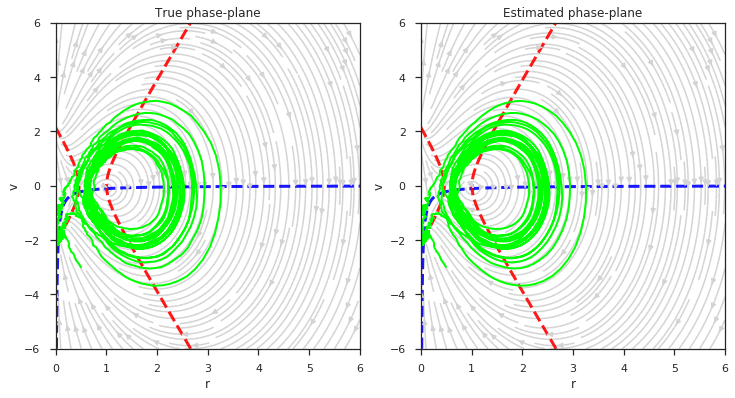

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
params_true=parameters[0]
xrange = (0, 6) 
yrange =(-6, 6)
plot_vector_field(ax[0], params_true, xrange, yrange)
ax[0].plot(rs,vs,  marker="o", markersize=0, lw=2, color='lime')
ax[0].set(xlabel='r',  title='True phase-plane')
ax[0].set(ylabel='v', )

params_est=parameters[1]
xrange = (0, 6) 
yrange =(-6, 6)
plot_vector_field(ax[1], params_est, xrange, yrange)
ax[1].plot(r_est_reg,v_est_reg,  marker="o", markersize=0, lw=2, color='lime')
ax[1].set(xlabel='r',  title='Estimated phase-plane')
ax[1].set(ylabel='v', )
plt.savefig(os.path.join(dir_data_output,"EtimatedPhasePlane_"+str(model)+"_chain_"+str(chain)+".png"))

plt.show()

# Posterior convergence and diagnostics

In [73]:
divergent__=fit['divergent__'][-nSample:][:,newaxis]
stepsize__=fit['stepsize__'][-nSample:][:,newaxis]

lp__=fit['lp__'][-nSample:][:,newaxis]
accept_stat__=fit['accept_stat__'][-nSample:][:,newaxis]
energy__=fit['energy__'][-nSample:][:,newaxis]

treedepth__=fit['treedepth__'][-nSample:][:,newaxis]
n_leapfrog__=fit['n_leapfrog__'][-nSample:][:,newaxis]


In [74]:
divergent__.shape,stepsize__.shape 

((2500, 1), (2500, 1))

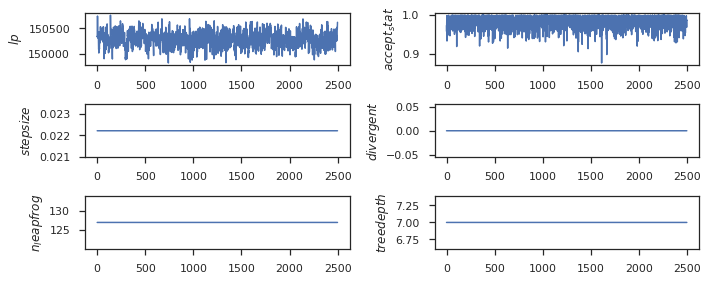

In [75]:
figure(figsize=(10, 4))

plt.subplot(321)
plt.plot(lp__, 'b')
plt.ylabel("$lp$")
plt.subplot(322)
plt.plot(accept_stat__, 'b')
plt.ylabel("$accept_stat$")

plt.subplot(323)
plt.plot(stepsize__, 'b')
plt.ylabel("$stepsize$")
plt.subplot(324)
plt.plot(divergent__, 'b')
plt.ylabel("$divergent$")

plt.subplot(325)
plt.plot(n_leapfrog__, 'b')
plt.ylabel("$n_leapfrog$")
plt.subplot(326)
plt.plot(treedepth__, 'b')
plt.ylabel("$treedepth$")

tight_layout()
plt.show()

In [76]:
from  report_diagnostics_stan import  run_summary, Nuts_plot, check_rhat, check_div, check_treedepth, check_energy, check_n_eff


In [77]:

dict_samples_diagnostics=read_samples(dir_data_output+"/"+str(fit_filename_csv), nwarmup=0, nsampling=num_samples,  variables_of_interest=['lp__', 'energy__', 'accept_stat__', 'divergent__', 'treedepth__', 'n_leapfrog__'  ])


In [78]:
lp__, accept_stat__, treedepth__, divergent__, energy__,  = dict_samples_diagnostics['lp__'], dict_samples_diagnostics['accept_stat__'],  dict_samples_diagnostics['treedepth__'], dict_samples_diagnostics['divergent__'], dict_samples_diagnostics['energy__']


In [79]:
check_divergence__=check_div(divergent__)
check_treedepth__=check_treedepth(treedepth__, int(max_depth))
check_energy__=check_energy(energy__)

In [80]:
check_divergence__, check_treedepth__, check_energy__

(0.0, 0.0, 0.6739458356717203)

In [81]:
lp=fit['lp__'][-nSample:][:,newaxis]
energy=fit['energy__'][-nSample:][:,newaxis]

In [82]:
lp.shape,energy.shape 

((2500, 1), (2500, 1))

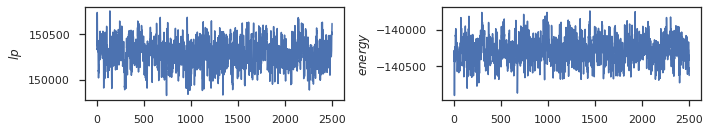

In [83]:
figure(figsize=(10, 2))
plt.subplot(121)
plt.plot(lp, 'b')
plt.ylabel("$lp$")
tight_layout()
plt.subplot(122)
plt.plot(energy, 'b')
plt.ylabel("$energy$")
tight_layout()
plt.show()

In [84]:
fit_summary=run_summary(cwd+"/", dir_data_output+"/"+str(fit_filename_csv))

fit_filefoder: data_output_hmc_MPR_cen_uniform
fit_filename: output_hmc_MPR_cen_uniform_1.csv
mycsvfile: /home/meysam/InferringRestingState/MontPazRoxin/NMM_MontPazRoxin/InferringMontPazRoxin_syntheticdata_I3sde1/data_output_hmc_MPR_cen_uniform/output_hmc_MPR_cen_uniform_1.csv
running stan summary!
finished stan summary!


In [85]:
cd ..


/home/meysam/InferringRestingState/MontPazRoxin/NMM_MontPazRoxin/InferringMontPazRoxin_syntheticdata_I3sde1


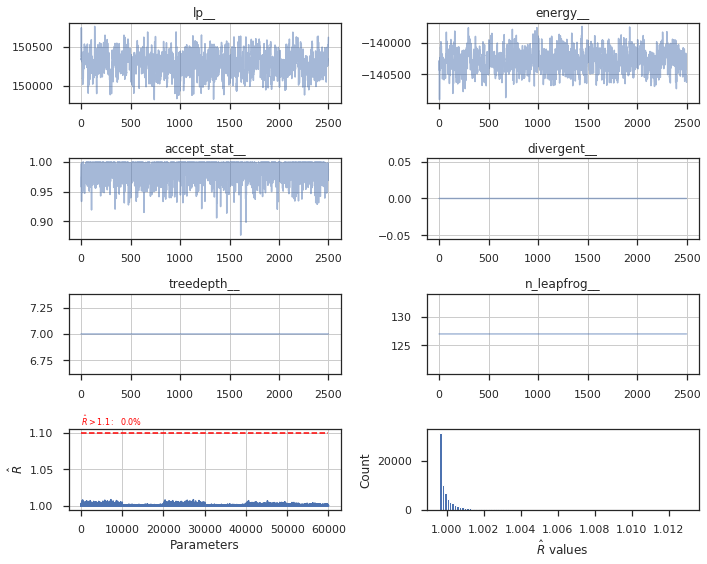

In [86]:
plt.figure(figsize=(10,8))
Nuts_plot(dict_samples_diagnostics, fit_summary)
plt.tight_layout()
plt.savefig(os.path.join(dir_data_output,"NUTS_diagnostics_"+str(model)+"_chain_"+str(chain)+".png"))
plt.show()

In [87]:
model

'MPR_cen_uniform'

# Covariance

In [88]:
# Covariance
def cov(x, y):
    xbar, ybar = x.mean(), y.mean()
    return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

# Covariance matrix
def cov_mat(X):
    return np.array([[cov(X[0], X[0]), cov(X[0], X[1])], \
                     [cov(X[1], X[0]), cov(X[1], X[1])]])


In [89]:
X=np.array([ eta_est[:,0], J_est[:,0]])
X.shape

(2, 2500)

In [90]:
X_mean=X.mean(axis=1)[:,np.newaxis]

In [91]:
Y=X-X_mean

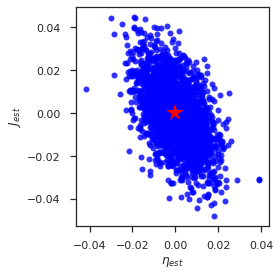

In [92]:
plt.figure(figsize=(4,4))
plt.plot(Y[0,:], Y[1,:], 'o', color='blue', alpha=0.8)
plt.plot(Y.mean(axis=1)[0], Y.mean(axis=1)[1], '*', color='red', markersize=18, alpha=1)
plt.xlabel("$\eta_{est}$")
plt.ylabel("$J_{est}$")
plt.axis('equal');
#plt.xticks([])
#plt.yticks([])
plt.tight_layout()
plt.show()

In [93]:
corrcoef(Y[0,:], Y[1,:])

array([[ 1.        , -0.50710963],
       [-0.50710963,  1.        ]])

In [94]:
C = cov_mat(Y)
C

array([[ 8.24107184e-05, -6.66088615e-05],
       [-6.66088615e-05,  2.09351757e-04]])

In [95]:
eVe, eVa = np.linalg.eig(C)
eVe.shape, eVa.shape

((2,), (2, 2))

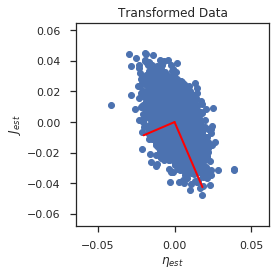

In [96]:
plt.figure(figsize=(4,4))

plt.scatter(Y[0,:], Y[1,:])
for e, v in zip(eVe, eVa.T):
    plt.plot([0, 3*np.sqrt(e)*v[0]], [0, 3*np.sqrt(e)*v[1]], color='red', linestyle='-', lw=2)
plt.title('Transformed Data')
plt.axis('equal');
plt.xlabel("$\eta_{est}$")
plt.ylabel("$J_{est}$")
#plt.xticks([])
#plt.yticks([])
plt.tight_layout()
plt.show()

In [97]:
Y.shape

(2, 2500)

In [98]:
# C = cov_mat(Y.T)

# # Calculate eigenvalues
# eVa, eVe = np.linalg.eig(C)

# # Calculate transformation matrix from eigen decomposition
# R, S = eVe, np.diag(np.sqrt(eVa))
# T = R.dot(S).T

# # Transform data with inverse transformation matrix T^-1
# Z = Y.dot(np.linalg.inv(T))

In [99]:
C = cov_mat(Y)

# Calculate eigenvalues
eVe, eVa = np.linalg.eig(C)

# Calculate transformation matrix from eigen decomposition
R, S = eVa, np.diag(np.sqrt(eVe))
T = R.dot(S).T

# Transform data with inverse transformation matrix T^-1
Z = Y.T.dot(np.linalg.inv(T)).T

In [100]:
Z.shape

(2, 2500)

In [101]:
corrcoef(Z[0,:], Z[1,:])

array([[ 1.00000000e+00, -1.46430376e-16],
       [-1.46430376e-16,  1.00000000e+00]])

In [102]:
# Covariance matrix of the uncorrelated data
C_z=cov_mat(Z)

eVe_z, eVa_z = np.linalg.eig(C_z)

In [103]:
eVe_z.shape, eVa_z.shape

((2,), (2, 2))

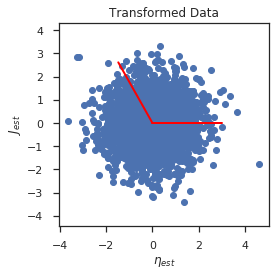

In [104]:
plt.figure(figsize=(4,4))

plt.scatter(Z[0,:], Z[1,:])

for e, v in zip(eVe_z, eVa_z.T):
    plt.plot([0, 3*np.sqrt(e)*v[0]], [0, 3*np.sqrt(e)*v[1]], color='red', linestyle='-', lw=2)
plt.title('Transformed Data')
plt.axis('equal');
plt.xlabel("$\eta_{est}$")
plt.ylabel("$J_{est}$")
#plt.xticks([])
#plt.yticks([])
plt.tight_layout()
plt.show()

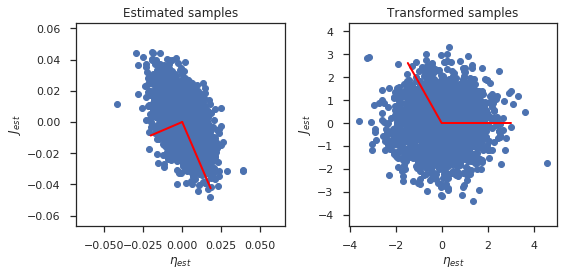

In [105]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.scatter(Y[0,:], Y[1,:])
for e, v in zip(eVe, eVa.T):
    plt.plot([0, 3*np.sqrt(e)*v[0]], [0, 3*np.sqrt(e)*v[1]], color='red', linestyle='-', lw=2)
plt.title('Estimated samples')
plt.axis('equal');
plt.xlabel("$\eta_{est}$")
plt.ylabel("$J_{est}$")
#plt.xticks([])
#plt.yticks([])

plt.subplot(122)
plt.scatter(Z[0,:], Z[1,:])

for e, v in zip(eVe_z, eVa_z.T):
    plt.plot([0, 3*np.sqrt(e)*v[0]], [0, 3*np.sqrt(e)*v[1]], color='red', linestyle='-', lw=2)
plt.title('Transformed samples')
plt.axis('equal');
plt.xlabel("$\eta_{est}$")
plt.ylabel("$J_{est}$")
#plt.xticks([])
#plt.yticks([])
plt.tight_layout()
plt.show()

In [106]:
import theano
import theano.tensor as tt
import pymc3 as pm

In [107]:
from matplotlib.patches import Ellipse

In [108]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.18.2
Running on theano: v1.0.4
Running on PYMC3: v3.8


In [109]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [110]:
import warnings
from warnings import filterwarnings
warnings.filterwarnings('ignore')
filterwarnings('ignore', message='findfont')

In [111]:
X=np.array([ eta_est[:,0], J_est[:,0]])
X.shape

(2, 2500)

In [112]:
X_mean=X.mean(axis=1)[:,np.newaxis]

In [113]:
Y=X-X_mean
Y.shape

(2, 2500)

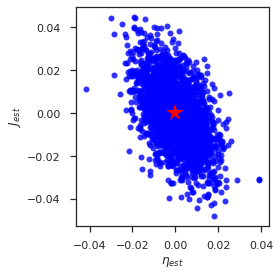

In [114]:
plt.figure(figsize=(4,4))
plt.plot(Y[0,:], Y[1,:], 'o', color='blue', alpha=0.8)
plt.plot(Y.mean(axis=1)[0], Y.mean(axis=1)[1], '*', color='red', markersize=18, alpha=1)
plt.xlabel("$\eta_{est}$")
plt.ylabel("$J_{est}$")
plt.axis('equal');
#plt.xticks([])
#plt.yticks([])
plt.tight_layout()
plt.show()

In [115]:
μ_actual=Y.mean(axis=1)
Σ_actual=cov_mat(Y)

In [116]:
var, U = np.linalg.eig(Σ_actual)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

In [117]:
angle

23.19103525638754

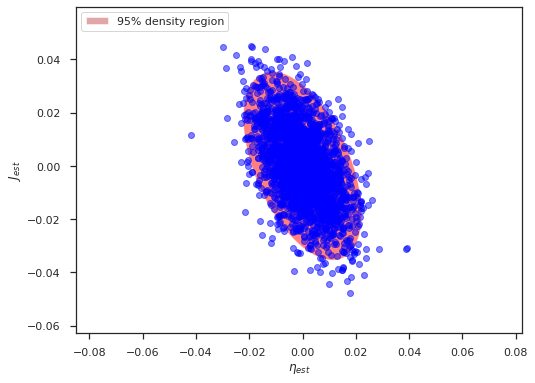

In [118]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(Y[0,:], Y[1,:], c='blue', alpha=0.5, zorder=11);

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)
e.set_alpha(0.5)
e.set_facecolor('red')
e.set_zorder(10);
ax.add_artist(e);


rect = plt.Rectangle((0, 0), 1, 1, fc='r', alpha=0.5)
ax.legend([rect], ['95% density region'], loc=2);

plt.xlabel("$\eta_{est}$")
plt.ylabel("$J_{est}$")
plt.axis('equal');

In [119]:
with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=2,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))

In [120]:
with model:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = pm.Deterministic('Σ', L.dot(L.T))

In [121]:
L.tag.test_value.shape

(2, 2)

In [122]:
with model:
    μ = pm.Normal('μ', 0., 10., shape=2, testval=Y.mean(axis=1))
    obs = pm.MvNormal('obs', μ, chol=L, observed=Y.T)

In [123]:
with model:
    step = pm.NUTS()
    trace = pm.sample(draws=2000, tune=2000, step=step)

INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [μ, packed_L]


INFO:pymc3:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 78 seconds.


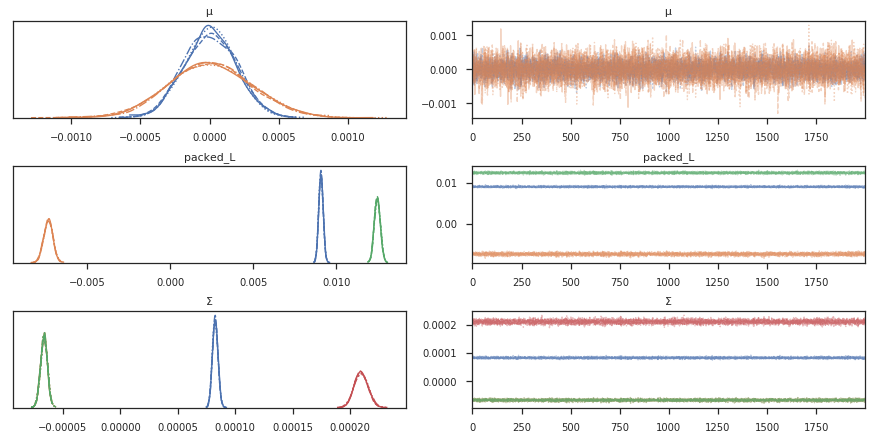

In [124]:
pm.traceplot(trace);

In [125]:
μ_post = trace['μ'].mean(axis=0)
μ_post

array([ 5.22753055e-07, -2.45346589e-07])

In [126]:
1 - μ_post / μ_actual

array([ 1.87920695e+09, -2.25535354e+08])

In [127]:
Σ_post = trace['Σ'].mean(axis=0)
Σ_post

array([[ 8.25133240e-05, -6.66116791e-05],
       [-6.66116791e-05,  2.09551257e-04]])

In [128]:
1 - Σ_post / Σ_actual

array([[-1.24505215e-03, -4.23007441e-05],
       [-4.23007441e-05, -9.52939096e-04]])

In [129]:
sd_actual = np.sqrt(np.diag(Σ_actual))
corr_actual = np.diag(sd_actual**-1).dot(Σ_actual.dot(np.diag(sd_actual**-1)))
corr_actual

array([[ 1.        , -0.50710963],
       [-0.50710963,  1.        ]])

In [130]:
sd_post = np.sqrt(np.diag(Σ_post))
corr_post = np.diag(sd_post**-1).dot(Σ_post.dot(np.diag(sd_post**-1)))
corr_post

array([[ 1.        , -0.50657436],
       [-0.50657436,  1.        ]])

In [131]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180. / np.pi * np.arccos(np.abs(U_post[0, 0]))

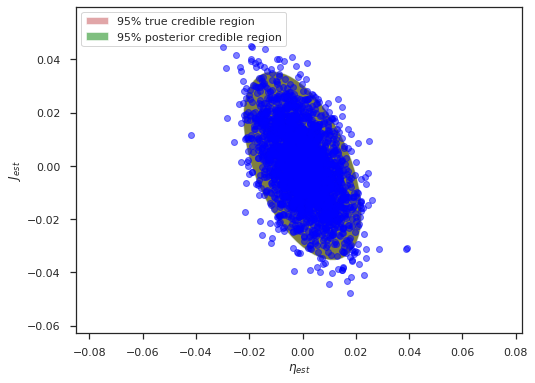

In [132]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(Y[0,:], Y[1,:], c='blue', alpha=0.5, zorder=11);

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)
e.set_alpha(0.5)
e.set_facecolor('red')
e.set_zorder(10);
ax.add_artist(e);


e_post = Ellipse(μ_post, 2 * np.sqrt(5.991 * var_post[0]),
                 2 * np.sqrt(5.991 * var_post[1]),
                 angle=angle_post)
e_post.set_alpha(0.5)
e_post.set_facecolor('green')
e_post.set_zorder(10);
ax.add_artist(e_post);


rect = plt.Rectangle((0, 0), 1, 1, fc='r', alpha=0.5)
post_rect = plt.Rectangle((0, 0), 1, 1, fc='green', alpha=0.5)
ax.legend([rect, post_rect],
          ['95% true credible region',
           '95% posterior credible region'],
          loc=2);
# ax.set_xlim(-4, 4)
plt.xlabel("$\eta_{est}$")
plt.ylabel("$J_{est}$")
plt.axis('equal');
plt.show()

In [133]:
Σ_post

array([[ 8.25133240e-05, -6.66116791e-05],
       [-6.66116791e-05,  2.09551257e-04]])

In [134]:
from scipy.linalg import fractional_matrix_power
from numpy.linalg import inv

In [135]:
C = cov_mat(Y)
C

array([[ 8.24107184e-05, -6.66088615e-05],
       [-6.66088615e-05,  2.09351757e-04]])

In [136]:
M=fractional_matrix_power(C, -.5)


In [137]:
M

array([[125.16786287,  25.84725599],
       [ 25.84725599,  75.90898868]])

In [138]:
inv(M)

array([[ 0.00859352, -0.00292612],
       [-0.00292612,  0.01417002]])

In [139]:
M=fractional_matrix_power(C, .5)
M

array([[ 0.00859352, -0.00292612],
       [-0.00292612,  0.01417002]])